##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

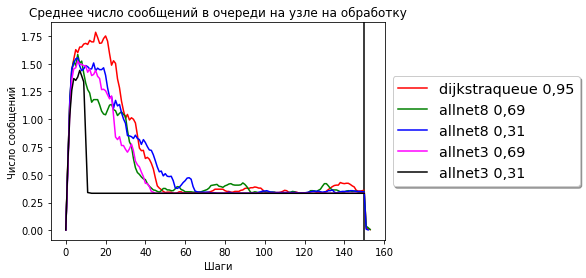

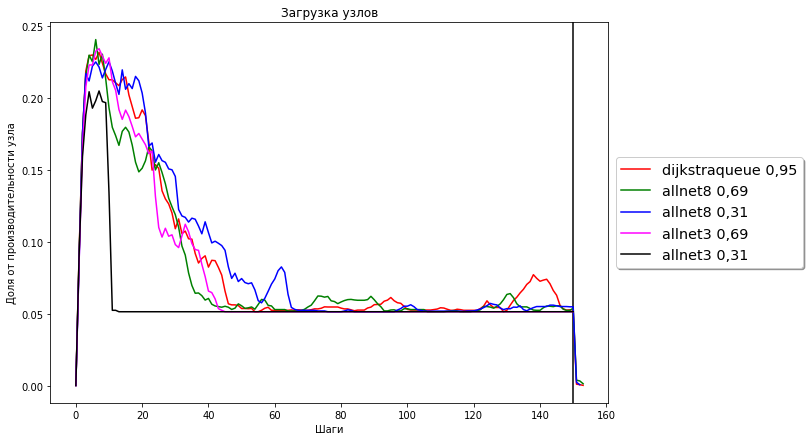

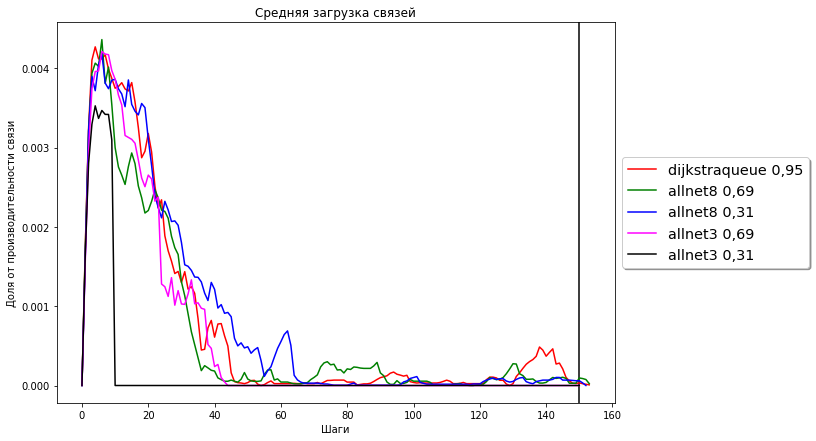

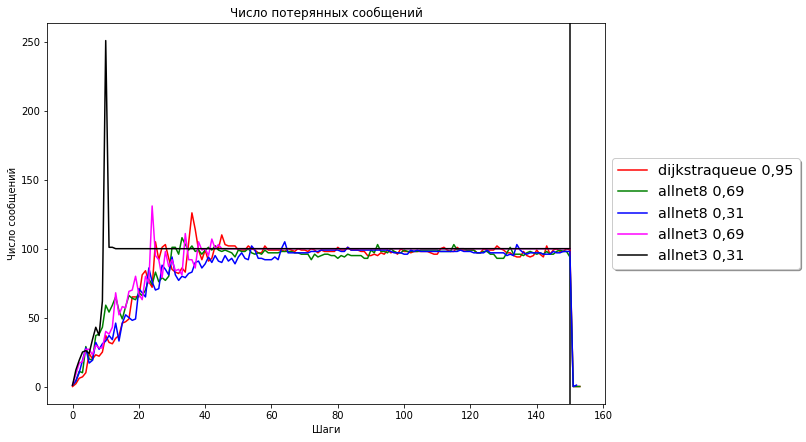

Доставлено 1668 Потеряно 88.8807% -dijkstraqueue 0,95
Доставлено 1652 Потеряно 88.9874% -allnet8 0,69
Доставлено 2020 Потеряно 86.5342% -allnet8 0,31
Доставлено 1319 Потеряно 91.2073% -allnet3 0,69
Доставлено 465 Потеряно 96.9002% -allnet3 0,31


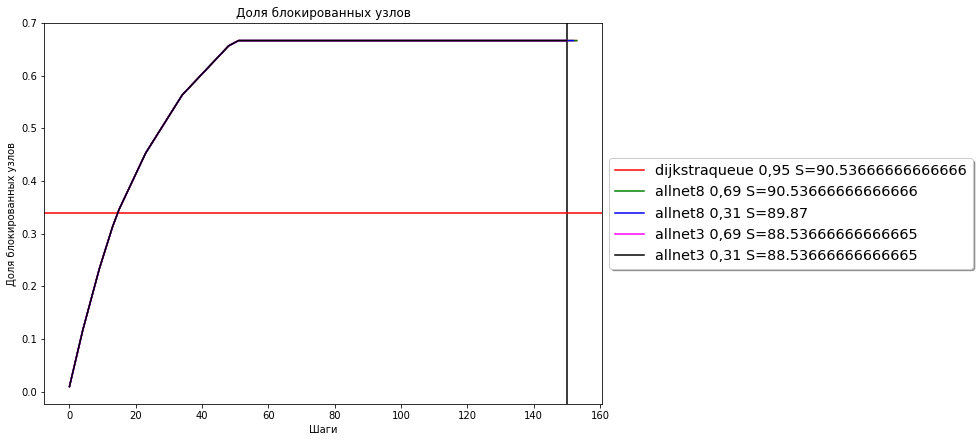

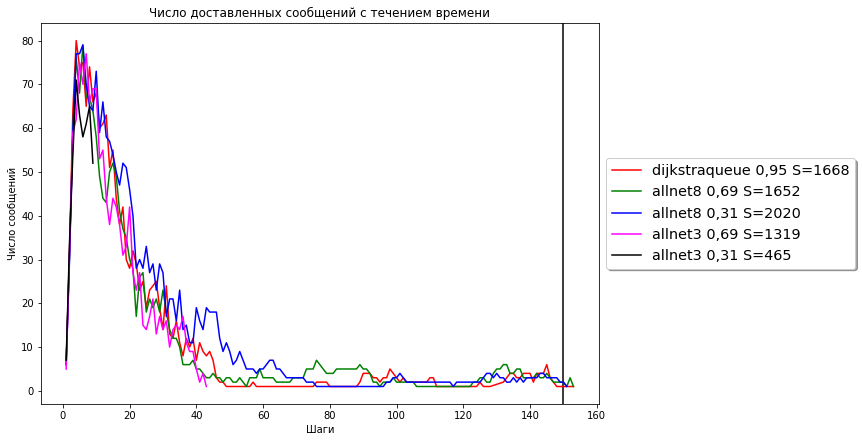

In [2]:
quantity = 100;
log_tags = [
{"tag":  "140724f2-82b3-45fe-98b5-6a6a0ce325c9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b7b431a3-101a-4eae-ba94-0ac58aff9cd2", "label": "allnet8 0,69", "color": "green"},
{"tag":  "fd1d5e4f-7764-4896-a667-4ddcba835a3a", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "a722ce56-2dde-4814-98eb-4da9749b3c73", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "0672c781-abd3-44ca-8d79-31199fcee1e8", "label": "allnet3 0,31", "color": "black"},

]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

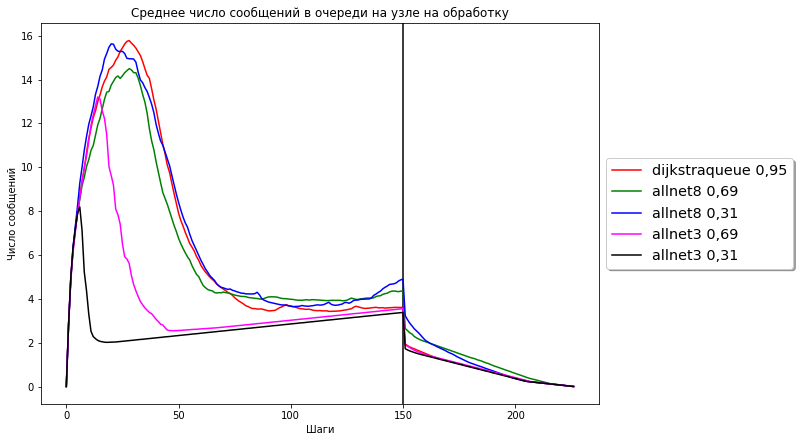

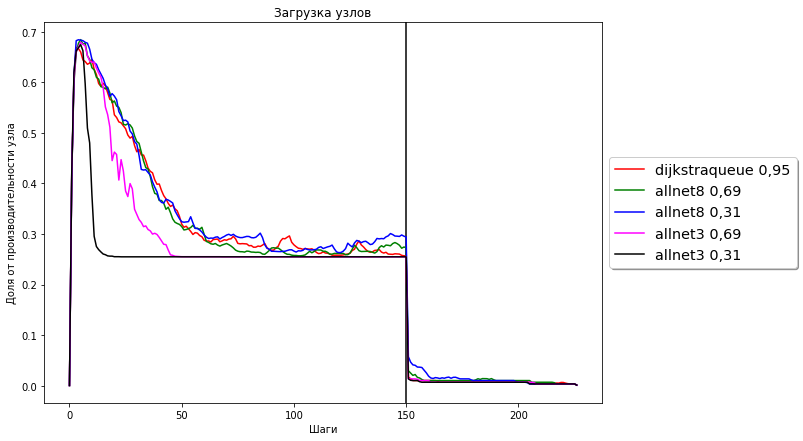

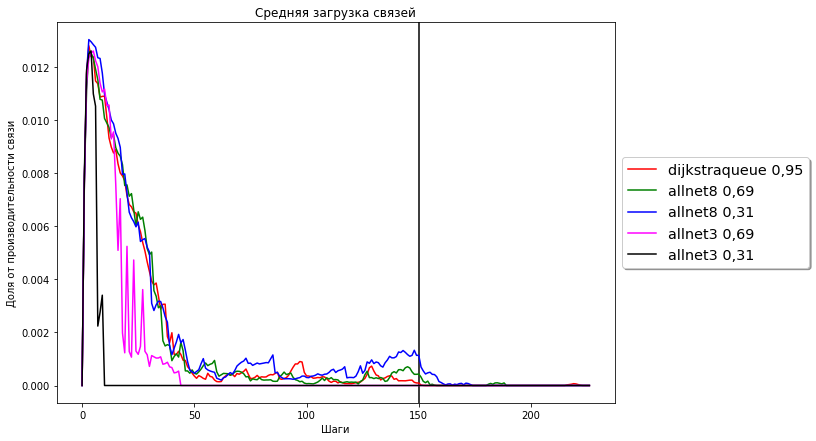

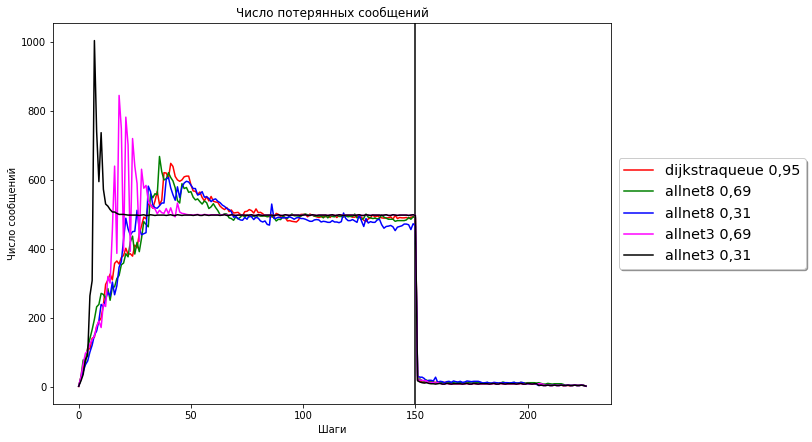

Доставлено 3840 Потеряно 94.8801% -dijkstraqueue 0,95
Доставлено 4434 Потеряно 94.0881% -allnet8 0,69
Доставлено 5067 Потеряно 93.2441% -allnet8 0,31
Доставлено 2739 Потеряно 96.3480% -allnet3 0,69
Доставлено 883 Потеряно 98.8227% -allnet3 0,31


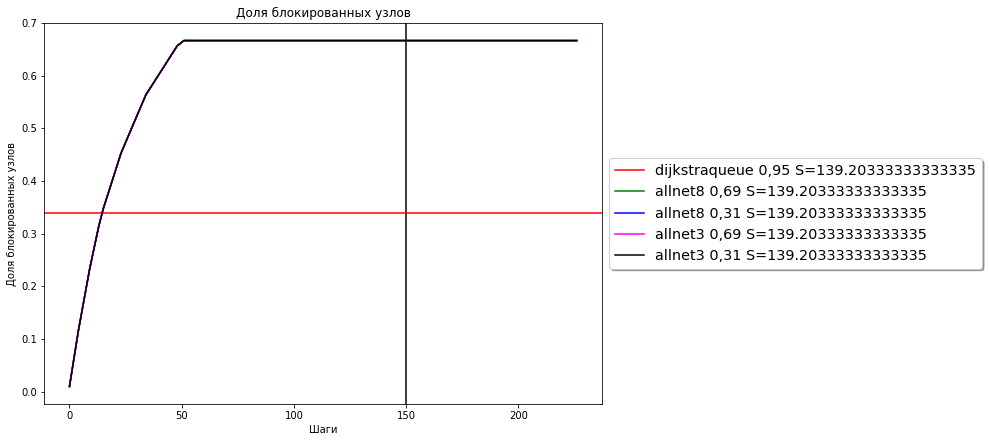

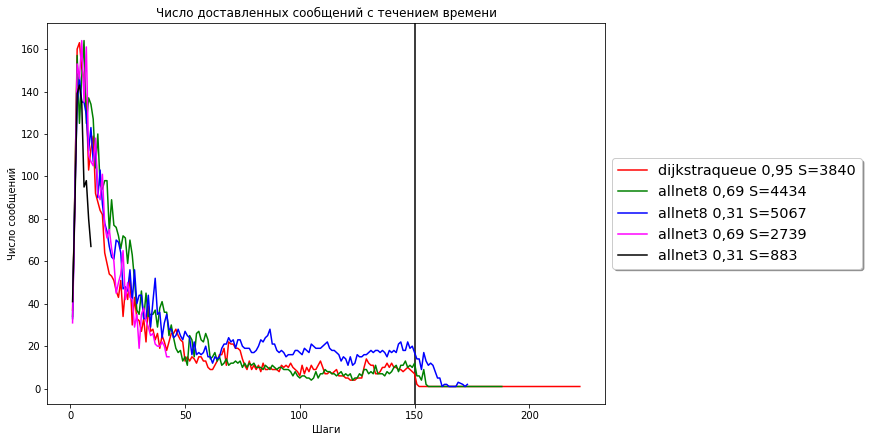

In [3]:
quantity = 500;
log_tags = [
{"tag":  "c3e7bbe1-8913-4423-8aec-091dcf9f71ce", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "010db151-fac9-4b58-976a-8ddf4a077050", "label": "allnet8 0,69", "color": "green"},
{"tag":  "93215ee6-fc9f-48a7-ac29-780bdbcd05fc", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "a5c17be4-6982-4c97-88e9-779d2b30f629", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "3b847011-5945-476c-b33a-cbb01443ce6f", "label": "allnet3 0,31", "color": "black"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

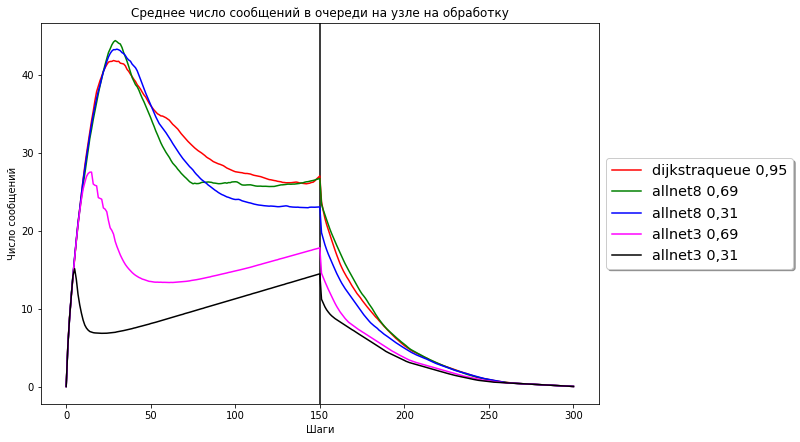

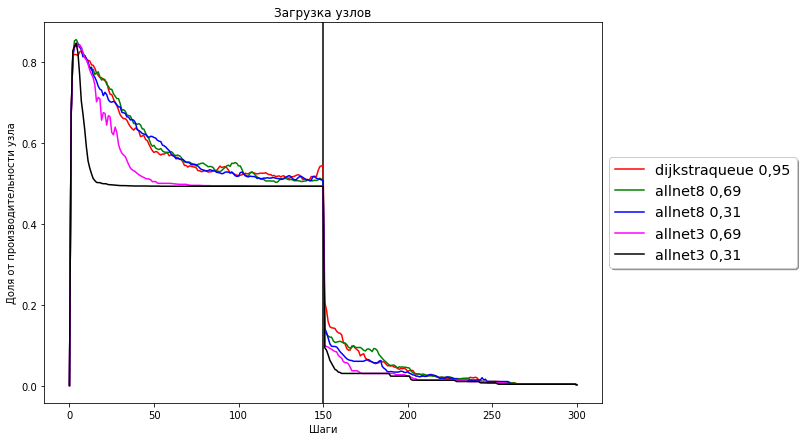

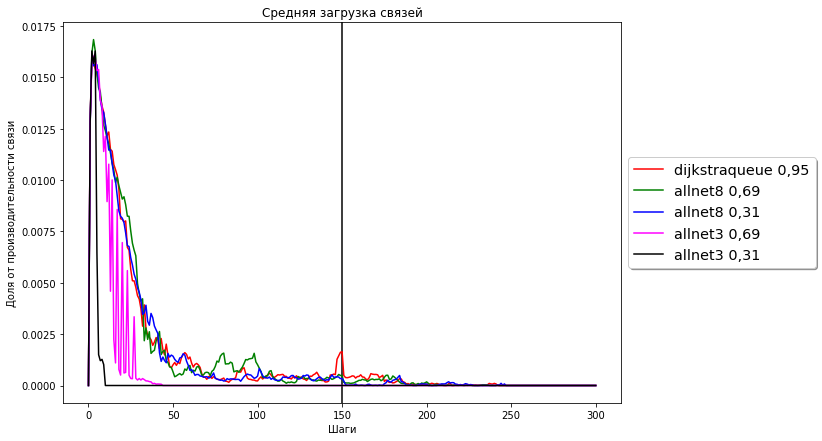

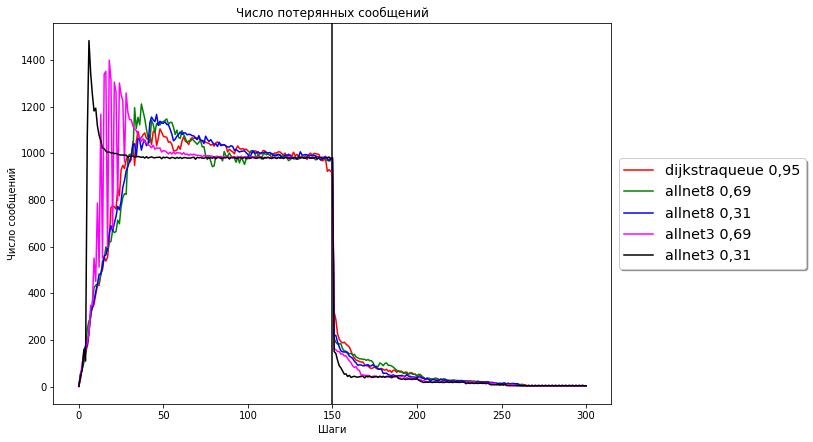

Доставлено 3854 Потеряно 97.4307% -dijkstraqueue 0,95
Доставлено 4421 Потеряно 97.0527% -allnet8 0,69
Доставлено 4011 Потеряно 97.3260% -allnet8 0,31
Доставлено 1967 Потеряно 98.6887% -allnet3 0,69
Доставлено 716 Потеряно 99.5227% -allnet3 0,31


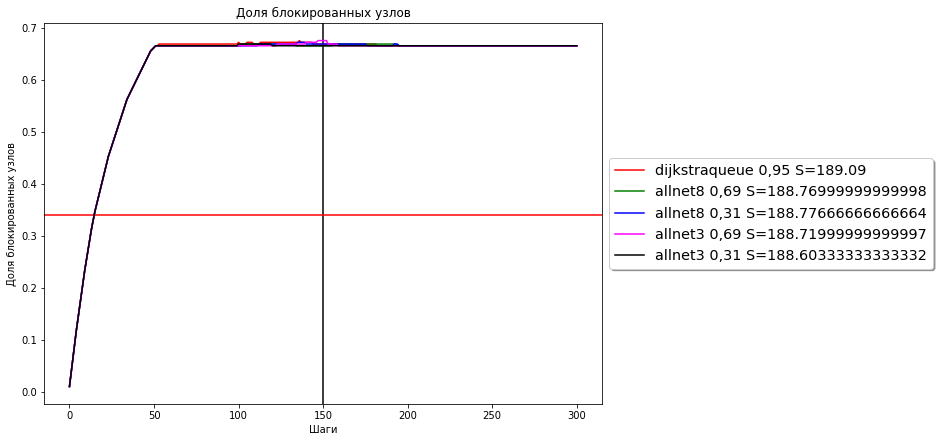

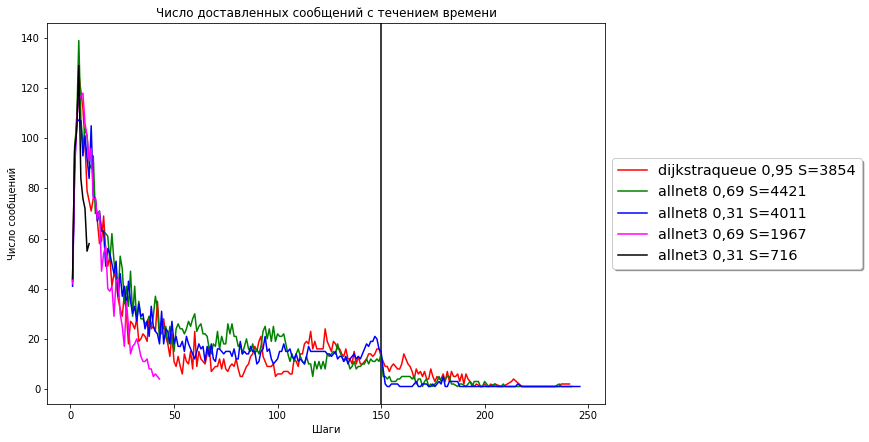

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "bcf4b149-94e3-4c4c-881c-4c6ffd87e819", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "02f0e7ea-aaa8-487b-a8b1-eee50ebf980a", "label": "allnet8 0,69", "color": "green"},
{"tag":  "641eaa42-db66-4683-a5d7-55ba26a33536", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "0f777980-3a07-4508-a6af-00372c54b234", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "5c32e01d-fc28-4422-b31e-0f9b0a1ff86c", "label": "allnet3 0,31", "color": "black"},

] 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

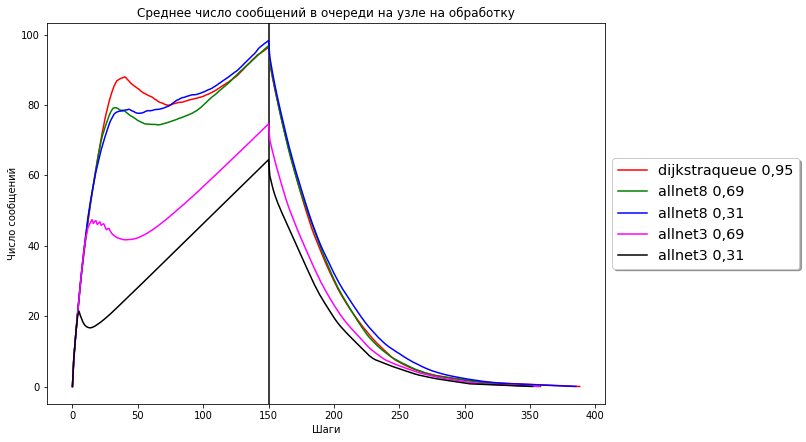

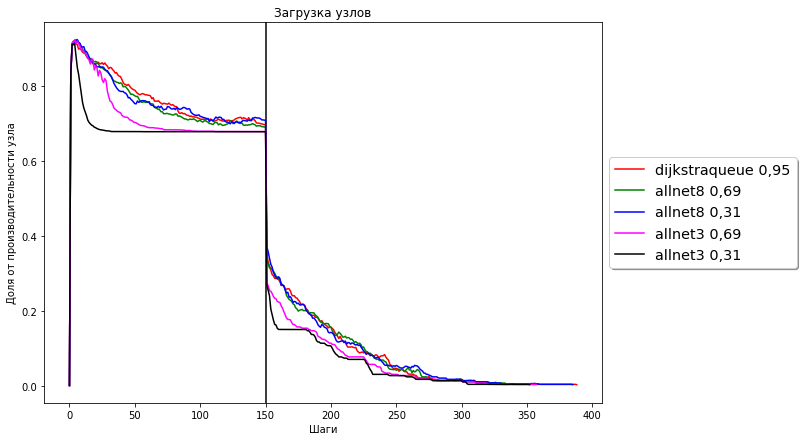

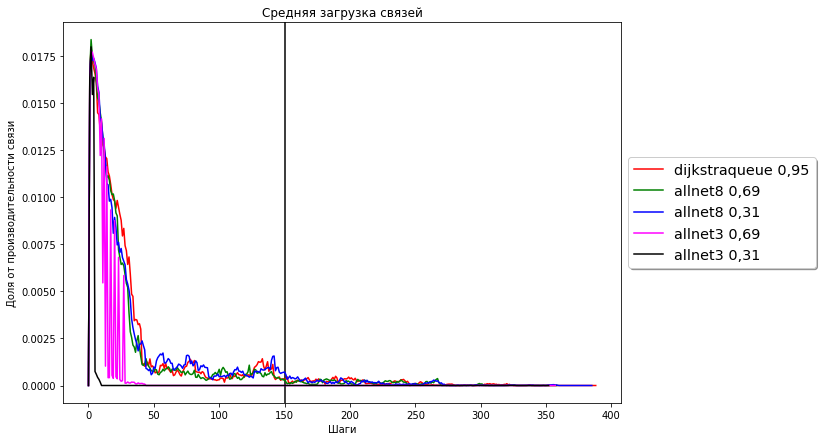

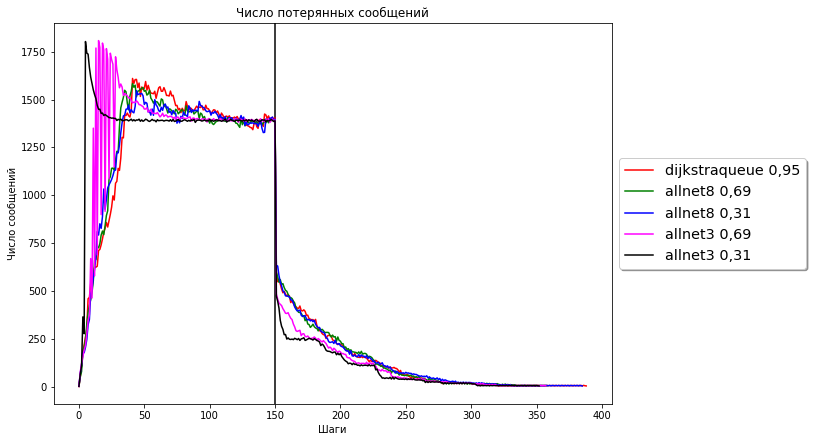

Доставлено 4379 Потеряно 98.0538% -dijkstraqueue 0,95
Доставлено 4333 Потеряно 98.0742% -allnet8 0,69
Доставлено 5043 Потеряно 97.7587% -allnet8 0,31
Доставлено 1607 Потеряно 99.2858% -allnet3 0,69
Доставлено 443 Потеряно 99.8031% -allnet3 0,31


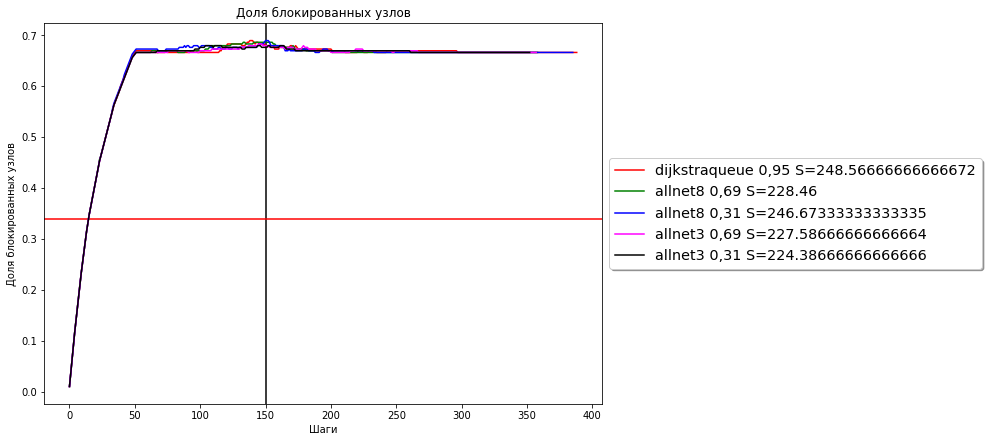

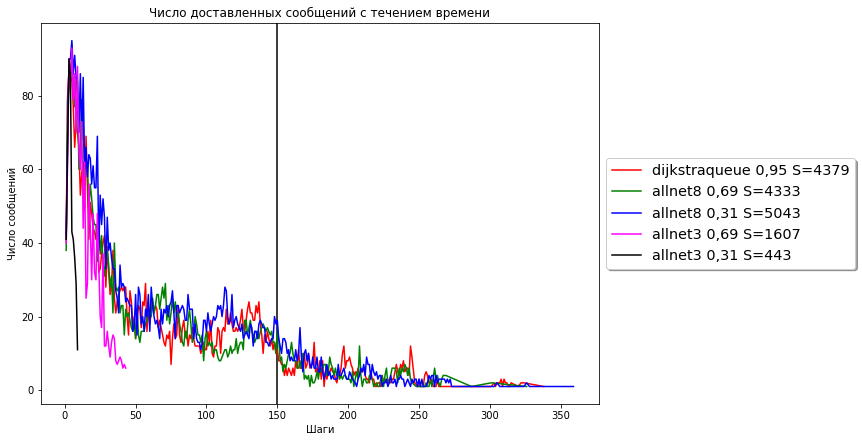

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "1f74d857-2ec2-48d1-842c-550c73215700", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c2a18130-0b2f-4b61-a36c-0c4df42ea867", "label": "allnet8 0,69", "color": "green"},
{"tag":  "7791a38c-7a13-4298-ba3f-64333cd30bff", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "d22a308d-1c8c-47b3-a132-19f500b38902", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "a1a26a2f-a29f-4775-a7db-a52952a2aa90", "label": "allnet3 0,31", "color": "black"},

] 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 3689 Потеряно 91.8024% -dijkstraqueue 0,95
Доставлено 3487 Потеряно 92.2513% -allnet8 0,69
Доставлено 3951 Потеряно 91.2202% -allnet8 0,31
Доставлено 3026 Потеряно 93.2757% -allnet3 0,69
Доставлено 962 Потеряно 97.8623% -allnet3 0,31


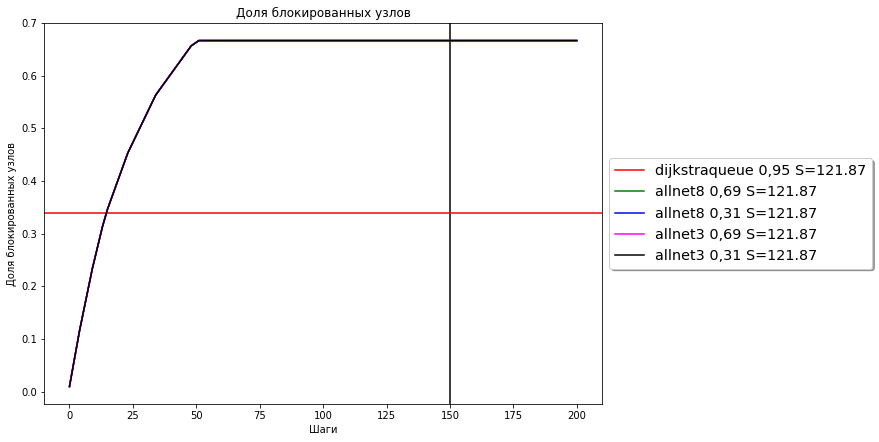

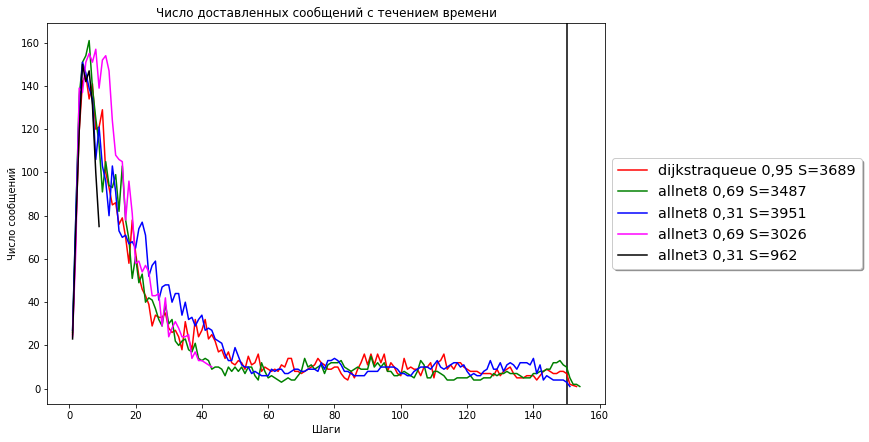

Доставлено 4587 Потеряно 95.6315% -dijkstraqueue 0,95
Доставлено 5172 Потеряно 95.0743% -allnet8 0,69
Доставлено 4458 Потеряно 95.7543% -allnet8 0,31
Доставлено 2170 Потеряно 97.9334% -allnet3 0,69
Доставлено 891 Потеряно 99.1514% -allnet3 0,31


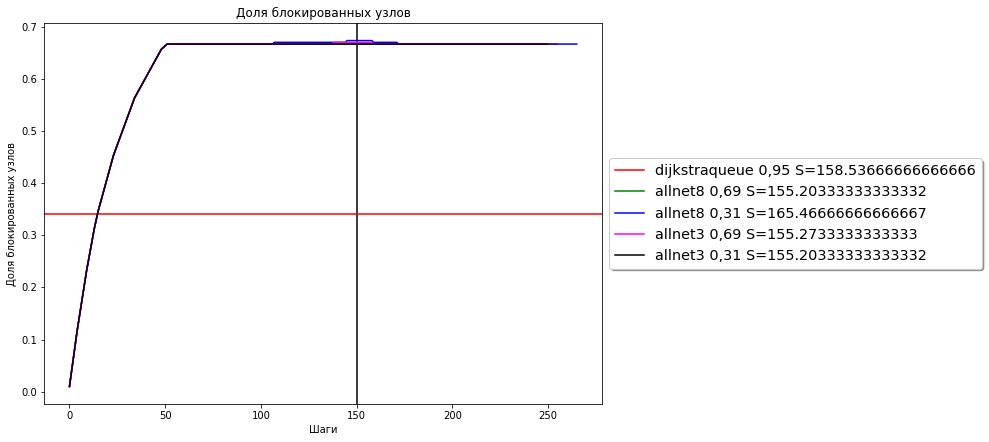

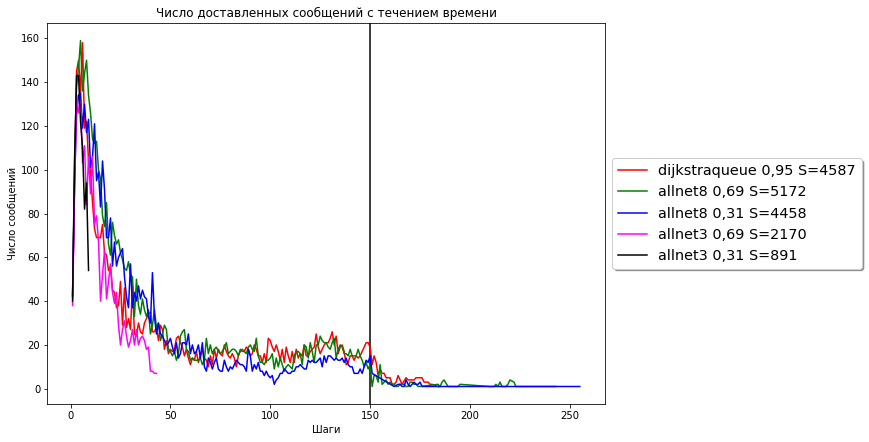

Доставлено 4127 Потеряно 96.9430% -dijkstraqueue 0,95
Доставлено 4437 Потеряно 96.7134% -allnet8 0,69
Доставлено 4328 Потеряно 96.7941% -allnet8 0,31
Доставлено 2175 Потеряно 98.3889% -allnet3 0,69
Доставлено 727 Потеряно 99.4615% -allnet3 0,31


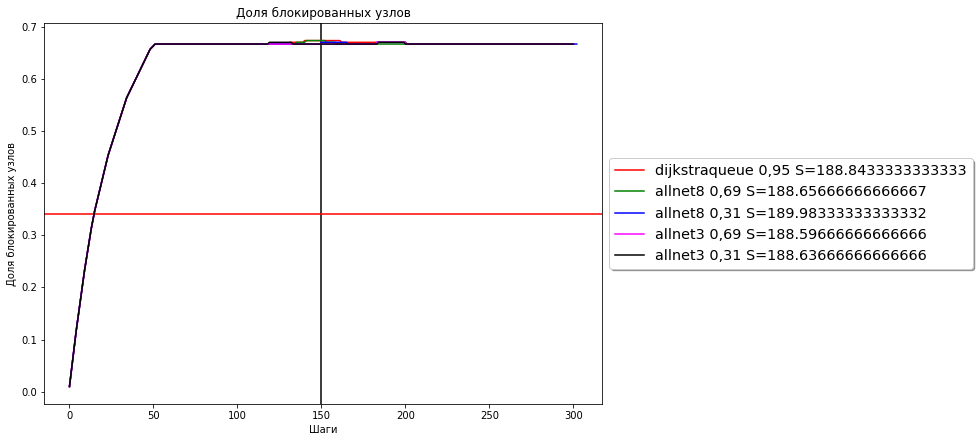

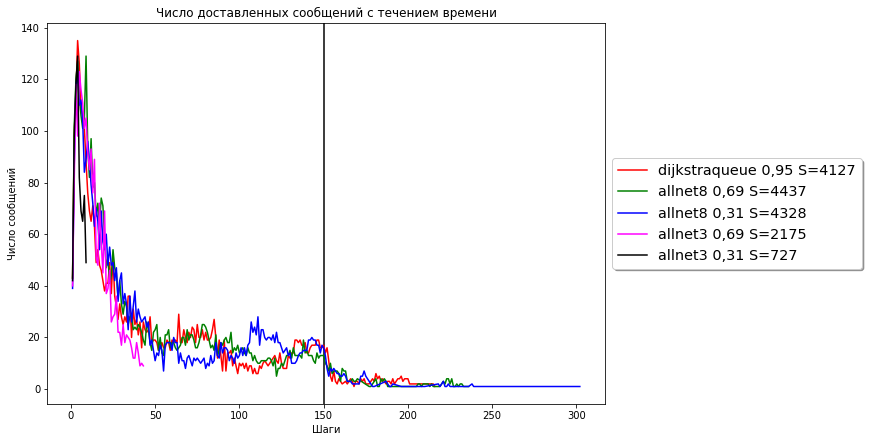

Доставлено 4384 Потеряно 97.7518% -dijkstraqueue 0,95
Доставлено 4660 Потеряно 97.6103% -allnet8 0,69
Доставлено 4110 Потеряно 97.8923% -allnet8 0,31
Доставлено 1866 Потеряно 99.0431% -allnet3 0,69
Доставлено 540 Потеряно 99.7231% -allnet3 0,31


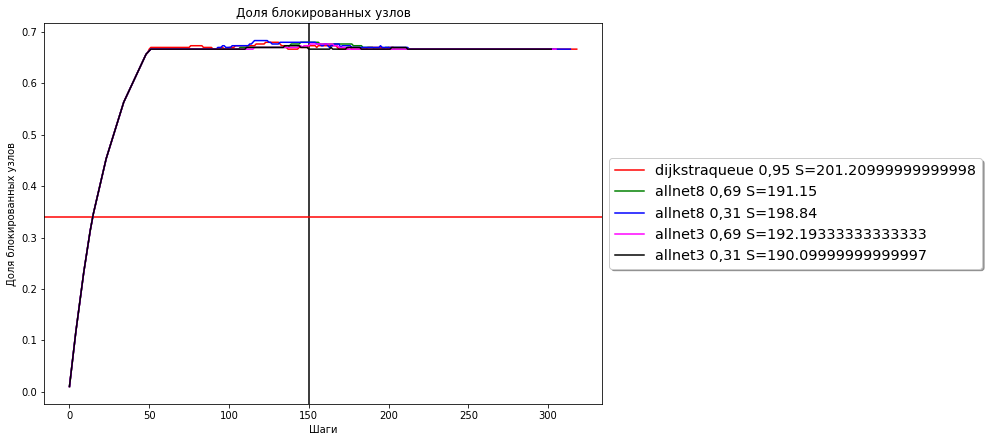

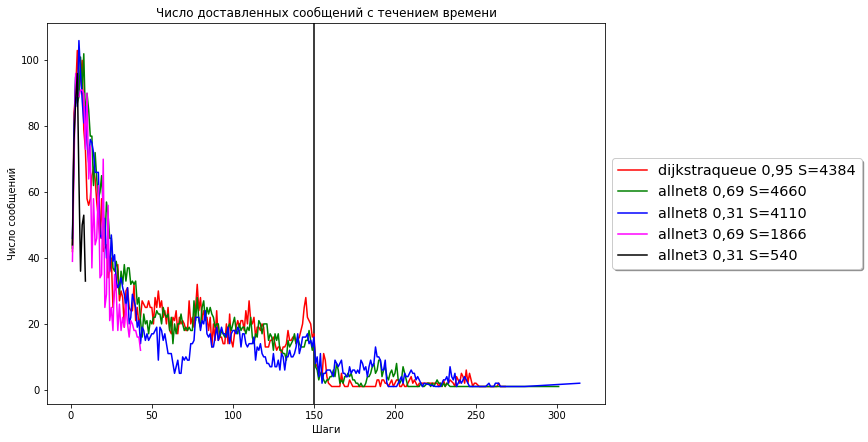

In [6]:
quantity = 300;
log_tags = [
{"tag":  "b82a499f-7735-4330-b989-02c5dfaa564b", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "d73a4e96-051f-4363-b755-113aa15597e8", "label": "allnet8 0,69", "color": "green"},
{"tag":  "e27056d2-1dc3-4806-862f-e5b26f9528d5", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "003865cb-c331-4b04-aec5-b8a543a7c2b1", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "d331fd8e-b018-4540-95f8-7f2b89d79a99", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "c2ffc1a8-80a6-4cd4-b5cc-493ae9debf76", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0ef443a2-261c-4ed9-81d3-386053a0d2d4", "label": "allnet8 0,69", "color": "green"},
{"tag":  "9ca26bc5-e1ab-4ecf-9c87-ef6388de4873", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "419e7ae2-d6d4-4dc7-973e-926227599b86", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "4adbda78-f598-41d5-842a-96cb5d5a5cdb", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "5b22af81-0b2a-433d-8f40-9e0b503717a0", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "278bdd54-8db4-4d3f-9324-3c26a7933101", "label": "allnet8 0,69", "color": "green"},
{"tag":  "2ea570a4-c6a5-4da5-97a1-326448ce5f44", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "94d1f5d5-c0a2-43c0-9558-8155d339f34d", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "6445a10c-28b9-4827-98c1-a44d09ba5aa3", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "6fc16b4f-d638-42d8-b39e-e4c83c7da15f", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f4ae687f-cb22-410f-a09a-5c0c51858420", "label": "allnet8 0,69", "color": "green"},
{"tag":  "ba1ab4ee-7359-4270-9f63-28b59ab92c7d", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "1b1c102b-b842-45d4-970e-7a943feb1c5c", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "b7cfdbd5-66ab-43dd-8c61-7667f88481ad", "label": "allnet3 0,31", "color": "black"},
]
showStatBlocked();  
showStatMessage();

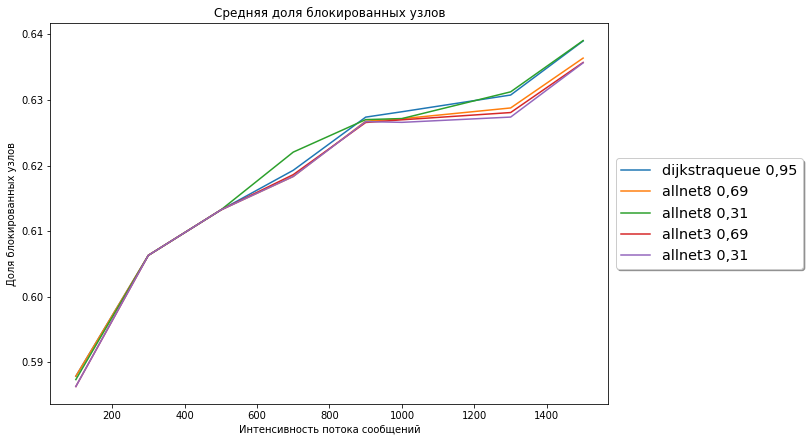

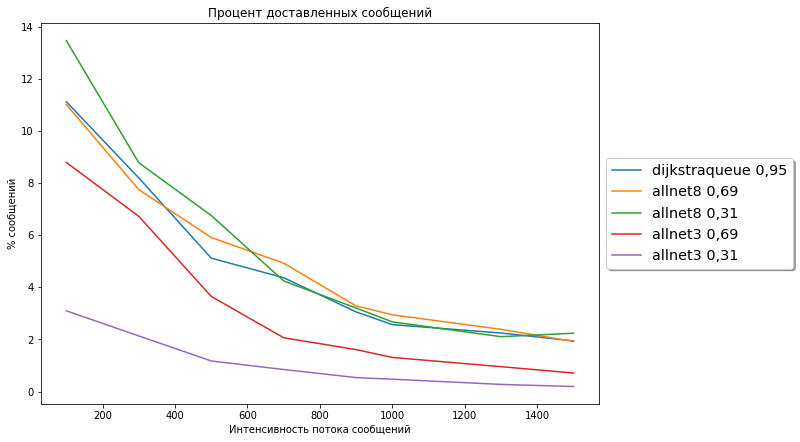

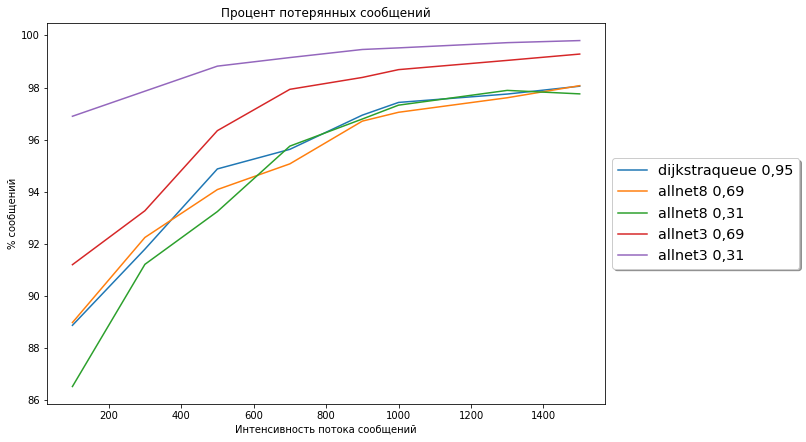

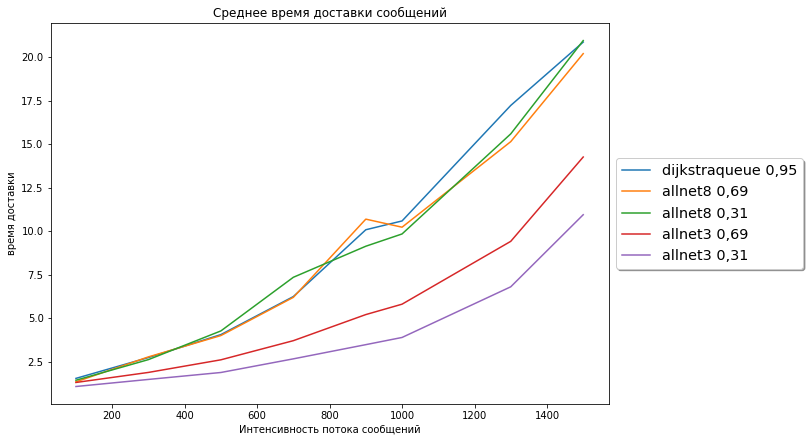

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.619008
allnet8 0,69          0.618108
allnet8 0,31          0.619181
allnet3 0,69          0.617731
allnet3 0,31          0.617570

dijkstraqueue 0,95    95.171743
allnet8 0,69          94.981455
allnet8 0,31          94.565494
allnet3 0,69          96.771350
allnet3 0,31          98.905868

dijkstraqueue 0,95    9.170348
allnet8 0,69          8.826754
allnet8 0,31          8.902601
allnet3 0,69          5.533027
allnet3 0,31          4.037969
